# Estimador OLS del VAR(1) es consistente e insesgado

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
from statsmodels.tsa.api import VAR

np.random.seed(1995)

%matplotlib inline

## El modelo

En este cuaderno simulamos realizaciones del VAR(1)

\begin{align*} 
x_t &= 0.8x_{t-1} + 0.7y_{t-1} + \epsilon_{x,t} \\
y_t &= -0.2x_{t-1} + 0.5y_{t-1} + \epsilon_{y,t}
\end{align*}

que puede escribirse
\begin{equation*}
\underset{Y_t}{\begin{pmatrix}x_t \\ y_t\end{pmatrix}} = 
\underset{\Phi}{\begin{pmatrix}0.8 & 0.7 \\ -0.2 & 0.5\end{pmatrix}}
\underset{Y_{t-1}}{\begin{pmatrix}x_{t-1} \\ y_{t-1}\end{pmatrix}} +
\underset{\epsilon_t}{\begin{pmatrix}\epsilon_{x,t} \\ \epsilon_{y,t}\end{pmatrix}}
\quad\qquad
\Omega = \begin{pmatrix}0.9 & 0 \\ 0 & 0.9\end{pmatrix}
\end{equation*}


y las utilizamos para estimar los párametros originales por OLS. El objetivo es ilustrar que este estimador está insesgado y que es consistente.

### Funciones auxiliares

Definimos las matrices de parámetros $\Phi$ y $\Omega$. Declaramos dos funciones: para simular una muestra de observaciones del VAR, y otra para estimar los coeficientes de $\Phi$ a partir de tales simulaciones. 

In [2]:
A = np.array([[0.8, 0.7], [-0.2, 0.5]])
sigma = 0.9

def var_sample(T = 100):
    ''' Simula el VAR(1) T períodos'''
    X = np.zeros((T,2))
    for t in range(1, T):
        X[t] = X[t-1] @ A.T + sigma * np.random.randn(2)
    
    trimestres = pd.date_range(start='1992q1',freq='d',periods=T)
    return pd.DataFrame(X, columns=['precio', 'cantidad'],index=trimestres)

def A_ols(data):
    '''Estima un VAR(1) a partir de datos, retorna coeficientes como vector'''
    return VAR(data).fit().coefs[0].flatten()


def estimaciones_var(T=100):
    return A_ols(var_sample(T))


from joblib import Parallel, delayed

def Monte_Carlo(funcion, repeticiones, columnas, *args, **kwargs):
    """
    Ejecuta simulaciones de Montecarlo en paralelo, aprovechando todos los núcleos del procesador

    Argumentos:
        funcion: una función que dé por resultado una única realización de las cantidades que se desean simular
        repeticiones: un entero que indica cuántas muestras se desean simular
        columnas: una lista (o tupla) de strings, que identifiquen a las cantidades individuales retornadas por funcion
        *args, **kwargs: otros parámetros requeridos por funcion

    Retorna:
         Un data frame de pandas, con tantas filas como `repeticiones` y columnas como textos en `columnas`.
    """
    datos = Parallel(n_jobs=-1)(delayed(funcion)(*args, **kwargs) for _ in range(repeticiones))
    return pd.DataFrame(datos, columns=columnas)

##  La estimación OLS de un VAR es insesgada

Obtenemos 10000 muestras de $T=100$ observaciones del VAR. Para cada muestra estimamos el VAR y colectamos los coeficientes estimados.

In [3]:
%%time
nrepetitions = 10000
estimates = Monte_Carlo(estimaciones_var, nrepetitions, ['$Φ_{11}$', '$Φ_{21}$', '$Φ_{12}$', '$Φ_{22}$'])

Wall time: 13.5 s


In [4]:
estimates.head()

,$Φ_{11}$,$Φ_{21}$,$Φ_{12}$,$Φ_{22}$
0,0.844947,0.665533,-0.248710,0.593978
1,0.716520,0.604271,-0.260401,0.324318
2,0.792525,0.814655,-0.202305,0.475453
3,0.638622,0.529020,-0.116859,0.405299
4,0.776426,0.750889,-0.231297,0.422044


Luego graficamos la distribución de cada columna (estimaciones de uno de los parámetros) con un histograma. Observe cómo la distribución estimada está centrada alrededor del verdadero parámetro en cada uno de los gráficos.

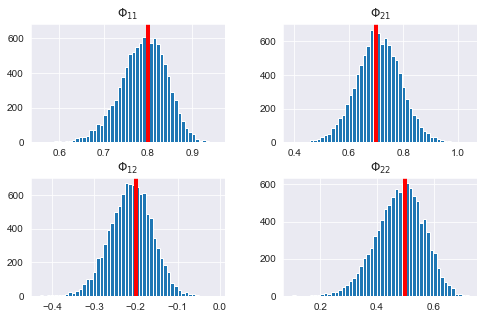

In [5]:
ax = estimates.hist(bins=50,figsize=[8,5])

for i in range(2):
    for j in range(2):
        ax[i,j].axvline(x=A[i,j],linewidth=4, color='r')
        
#plt.gcf().savefig('imag/var-insesgado.pdf',bbox_inches='tight')        

##  La estimación OLS de un VAR es consistente

Para ilustrar que la estimación OLS de un VAR es consistente, simulamos una sola muestra de datos y vamos agregando una nueva observación. En cada paso estimamos el VAR con OLS. Observe que conforme aumenta el número de observaciones, los valores estimados convergen a los parámetros poblacionales.

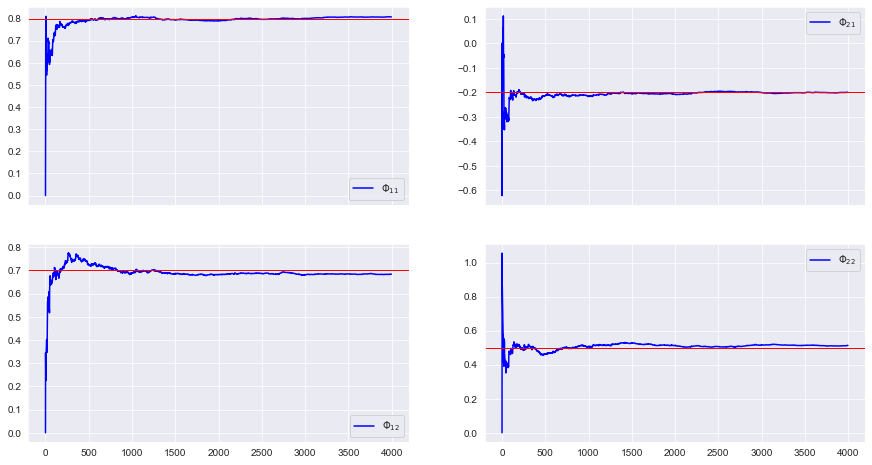

In [6]:
xlag = np.zeros([2,1])
XpX = np.zeros([2,2])
XpY = np.zeros([2,2])

T = 4000
minT = 4
Xest = np.zeros([T+1, 4])

for t in range(T+1):
    x = A @ xlag + sigma * np.random.randn(2,1)
    XpX += np.outer(xlag, xlag)
    XpY += np.outer(xlag, x)
    xlag = x.copy()
    
    if t>minT:
        Xest[t] = np.linalg.solve(XpX/t, XpY/t).flatten()
    
    
estimates2 = pd.DataFrame(Xest[minT:], columns=['$Φ_{11}$', '$Φ_{21}$', '$Φ_{12}$', '$Φ_{22}$'])

ax = estimates2.plot(color='b',figsize=[15,8],subplots=True, layout=[2,2])

for i in range(2):
    for j in range(2):
        ax[i,j].axhline(y=A[j,i],linewidth=1, color='r')

#plt.gcf().savefig('imag/var-consistente.pdf',bbox_inches='tight') 